In [3]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [6]:
df = pd.read_csv('../processed_data/merged_data_2013-2022.csv')
df = df.drop(columns=["Unnamed: 0"])

# Exploratory analysis:

In [ ]:
# data overview
print(f"Dataset shape: {df.shape}")
print(f"Counties: {df['county'].nunique()}")
print(f"Years: {df['year'].unique()}")
print(f"\nMissing values: {df.isnull().sum()}")
#print(df.describe())

simple visualizations of the relationship between aqi and asthma rates:

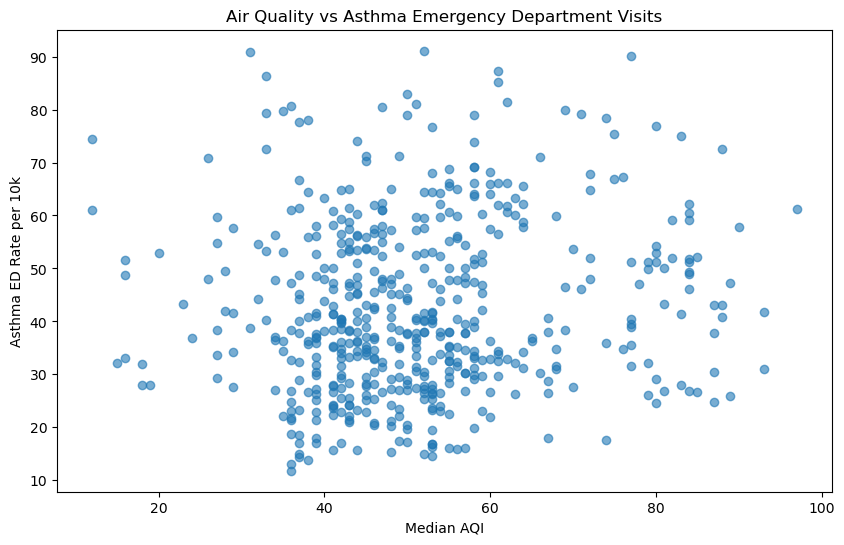

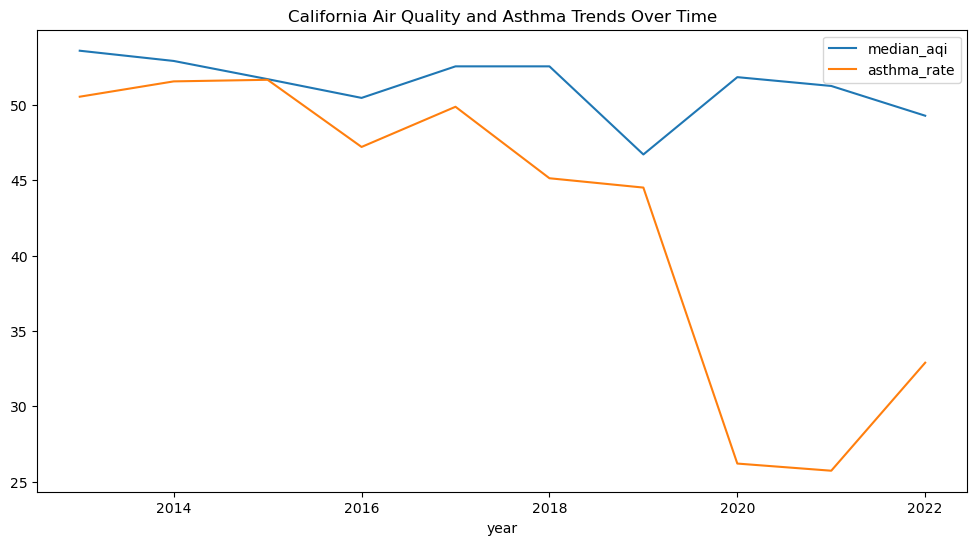

In [5]:
#  median aqi vs asthma rate - scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['median_aqi'], df['asthma_rate'], alpha=0.6)
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED Rate per 10k')
plt.title('Air Quality vs Asthma Emergency Department Visits')
plt.show()

# time trends analysis - line plot
yearly_trends = df.groupby('year')[['median_aqi', 'asthma_rate']].mean()
yearly_trends.plot(kind='line', figsize=(12, 6))
plt.title('California Air Quality and Asthma Trends Over Time')
plt.show()

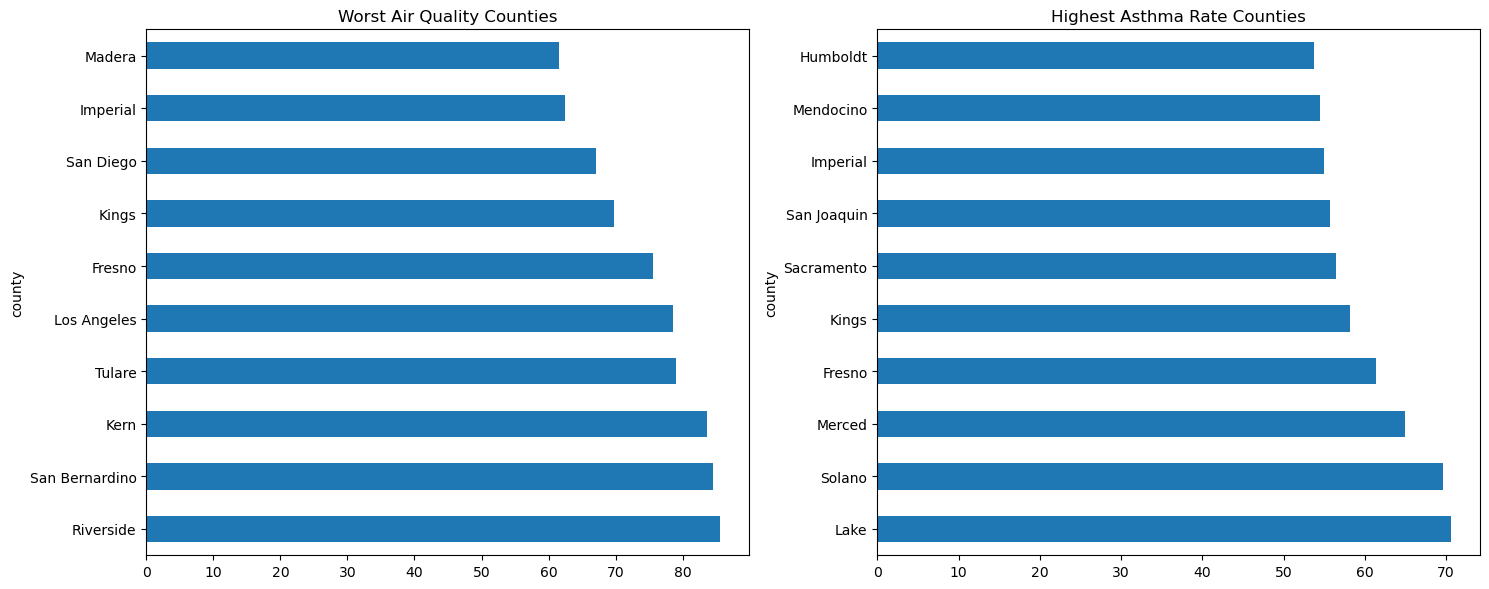

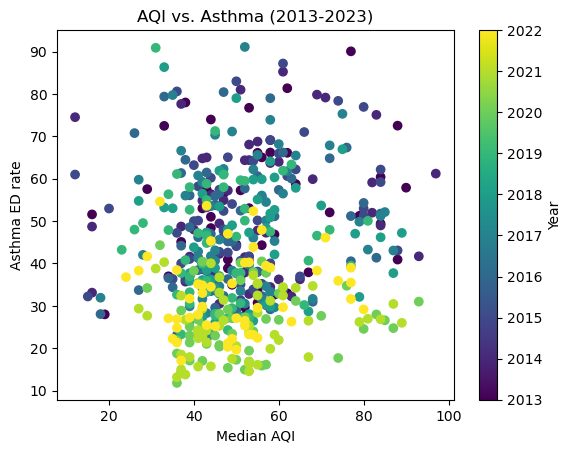

In [6]:
# top counties with worst aqi and highest asthma rates - bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
worst_aqi.head(10).plot(kind='barh', ax=ax1, title='Worst Air Quality Counties')
highest_asthma.head(10).plot(kind='barh', ax=ax2, title='Highest Asthma Rate Counties')
plt.tight_layout()
plt.show()

# median aqi vs asthma rate colored by year - scatter plot
plt.scatter(df['median_aqi'], df['asthma_rate'], c=df['year'])
plt.xlabel('Median AQI')
plt.ylabel('Asthma ED rate')
plt.title('AQI vs. Asthma (2013-2023)')
plt.colorbar(label='Year')
plt.show()

In [10]:
# simple correlation analysis (correlation coefficient)
correlation = df['median_aqi'].corr(df['asthma_rate'])
print(f"Correlation between AQI and Asthma rates: {correlation:.3f}")

Correlation between AQI and Asthma rates: 0.110


# Modeling:

In [ ]:
# simple OLS regression model
# note: this fit does not account for the whole strength of the relationship
model = smf.ols("asthma_rate ~ median_aqi", data=df).fit()
print(model.summary())

using more complex modeling to explore further on the complex relationship:

In [7]:
# multiple OLS regression model
# note: more complex model but gave much more stronger relationship between aqi and asthma rate

# "aqi vs. asthma rate by county and year"
model = smf.ols('asthma_rate ~ median_aqi + C(county) + C(year)', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            asthma_rate   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     52.90
Date:                Fri, 27 Jun 2025   Prob (F-statistic):          6.40e-174
Time:                        23:23:03   Log-Likelihood:                -1677.4
No. Observations:                 529   AIC:                             3481.
Df Residuals:                     466   BIC:                             3750.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [8]:
# extracting the observed, predicted, and residuals
y = df['asthma_rate']
y_pred  = model.fittedvalues
residuals = df['asthma_rate'] - y_pred

visualizations of the regression results:

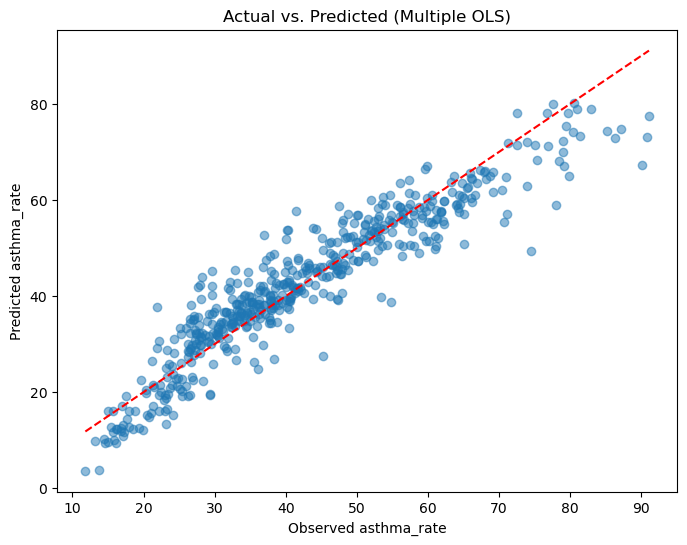

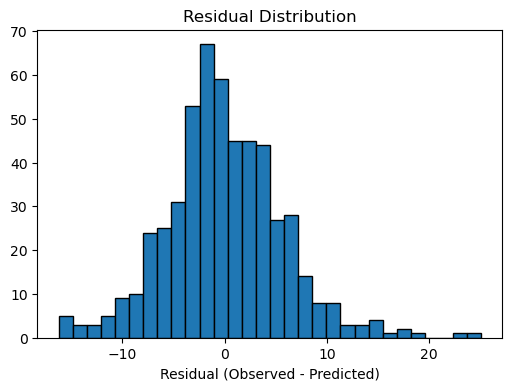

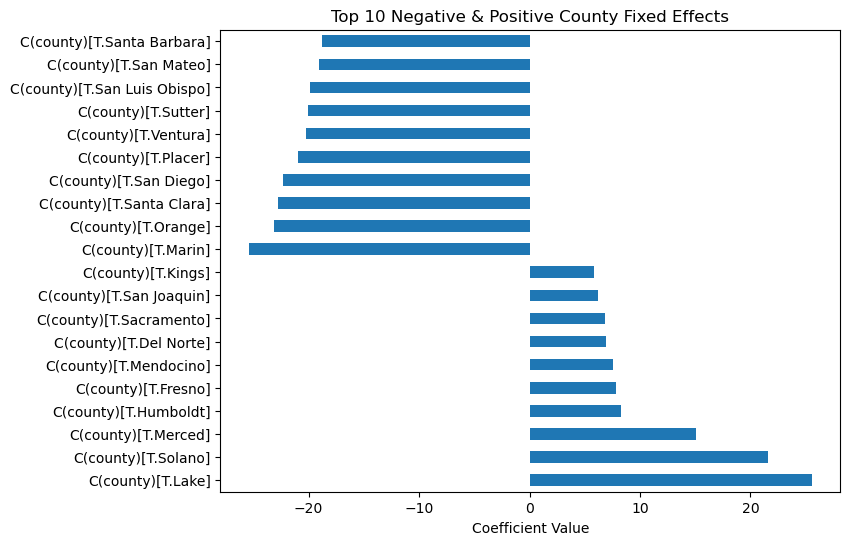

In [9]:
# actual vs. predicted scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Observed asthma_rate')
plt.ylabel('Predicted asthma_rate')
plt.title('Actual vs. Predicted (Multiple OLS)')
plt.show()

# residuals distribution histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual (Observed - Predicted)')
plt.title('Residual Distribution')
plt.show()

# top county fixed effects
coefs = model.params.filter(like='C(county)')
top_pos = coefs.sort_values(ascending=False).head(10) # plot top 10 positive
top_neg = coefs.sort_values().head(10) # plot top 10 negative
plot_coefs = pd.concat([top_pos, top_neg])

plt.figure(figsize=(8,6))
plot_coefs.plot(kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Negative & Positive County Fixed Effects')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import numpy as np

in sample test (to find RSME of above multiple ols regression model)

In [ ]:
mse  = mean_squared_error(df['asthma_rate'], df['y_pred'])
rmse = np.sqrt(mse)
print("RMSE:", rmse)

out of sample test (to find RSME):

In [ ]:
# split merged df into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# fit the OLS on the training set
model_train = smf.ols('asthma_rate ~ median_aqi + C(county) + C(year)', data=train_df).fit()

# predict on test set
test_df['y_pred_test'] = model_train.predict(test_df)

# evaluate
mse_test = mean_squared_error(test_df['asthma_rate'], test_df['y_pred_test'])
rmse_test = np.sqrt(mse_test)
print("Test-set RMSE:", rmse_test)

In [ ]:
mean_rate = df['asthma_rate'].mean()
relative_rmse = rmse_test / mean_rate
print(relative_rmse)

0.17562529888684628
